In [15]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from time import sleep
from sendgrid import SendGridAPIClient
from sendgrid.helpers.mail import Mail
from selenium.webdriver.common.action_chains import ActionChains
from collections import Counter
import re 
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd  
import numpy as np
from sklearn import naive_bayes
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sklearn.model_selection as ms
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [97]:
hrome_options = Options()
driver = webdriver.Chrome('C:\Program Files (x86)\chromedriver.exe')
url = 'https://www.rottentomatoes.com/m/mortal_kombat_2021/reviews?type=verified_audience'
driver.get(url)
#wait for the page to load
sleep(5)

In [ ]:
#Scrapping data
reviews=[]
stars=[]

for i in range(100):
    for review in driver.find_elements_by_class_name('audience-reviews__review-wrap'):
        reviews.append(review.find_elements_by_class_name('audience-reviews__review')[-1].text)
        stars.append(5-len(review.find_elements_by_class_name('star-display__empty')))
    
    driver.find_elements_by_class_name('prev-next-paging__button-text')[-1].click()
    sleep(3)
#Creating the dataset    
L={'Reviews': reviews,'Stars': stars}
df = pd.DataFrame(L, columns=['Reviews', 'Stars'])            
df.to_csv('Movie_Reviews.csv', index=False, encoding='utf-8') 

In [99]:
df.head(5)

,Reviews,Stars
0,Tacky. Horrible plot. Didn't even get to this ...,1
1,Was a decent watch. What I thought would be an...,3
2,Great movie to watch with the family,5
3,"felt a little rushed, could have been better.",3
4,the fight scenes where awesome and it did not ...,4


In [100]:
#Deleting emojis and flags from the reviews text
def delEmoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F1E0-\U0001F1FF"  
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

df.Reviews=df.Reviews.apply(delEmoji)

In [101]:
#Creating a matrix of token counts
vectoriser = CountVectorizer(lowercase=True,stop_words='english',binary=True)
X = vectoriser.fit_transform(df.Reviews)


In [121]:
#Spliting the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, df['Stars'],test_size=0.2, stratify=df['Stars'])
#Choosing the optimal alpha value
alphas = list(range(1,21))
n_grid = [{'alpha': alphas}]
cv = GridSearchCV(estimator=naive_bayes.MultinomialNB().fit(X_train, y_train),param_grid=n_grid,cv=ms.KFold(n_splits=10))
cv.fit(X_train, y_train)
best_alpha = cv.best_params_['alpha']

#Initiating the model
model = naive_bayes.MultinomialNB(alpha=best_alpha).fit(X_train, y_train)


5    514
4    281
3    121
2     47
1     37
Name: Stars, dtype: int64

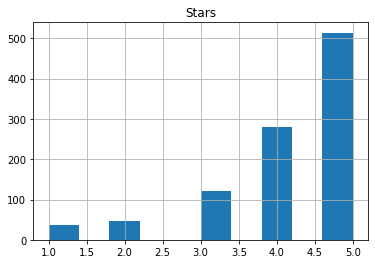

In [139]:
df.hist()
df.Stars.value_counts()

In [122]:
#Printing the confusion_matrix
print(confusion_matrix(y_test,model.predict(X_test)),'\n')
print(classification_report(y_test,model.predict(X_test)))

[[ 3  0  0  3  1]
 [ 0  0  0  6  4]
 [ 0  1  5 12  6]
 [ 0  0  3 27 26]
 [ 0  0  0 23 80]] 

              precision    recall  f1-score   support

           1       1.00      0.43      0.60         7
           2       0.00      0.00      0.00        10
           3       0.62      0.21      0.31        24
           4       0.38      0.48      0.43        56
           5       0.68      0.78      0.73       103

    accuracy                           0.57       200
   macro avg       0.54      0.38      0.41       200
weighted avg       0.57      0.57      0.55       200



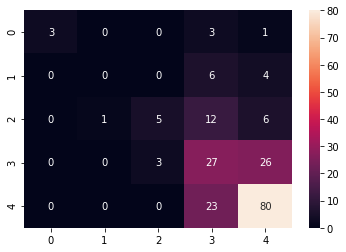

In [123]:
import numpy as np
import seaborn as sns0
ax = sns.heatmap(confusion_matrix(y_test,model.predict(X_test)), annot=True, fmt="d")